Source: https://nznano.blogspot.com/2017/11/molecular-dynamics-in-python.html

In [15]:
#Import a plotting libraries and a maths library
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


In [16]:
r = np.linspace(0.01,3.0,num=500) # Make a radius vector
epsilon = 1 # Energy minimum
sigma = 1 # Distance to zero crossing point
E_LJ = 4*epsilon*((sigma/r)**12-(sigma/r)**6) # Lennard-Jones potential


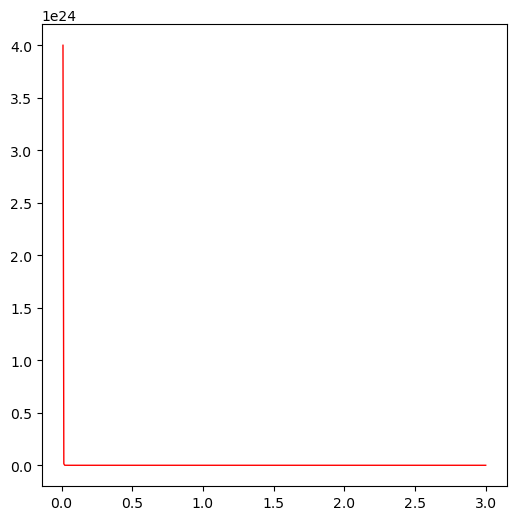

In [17]:
plt.figure(figsize=[6,6])
plt.plot(r,E_LJ,'r-',linewidth=1,label=r" $LJ\; pot$") # Red line is unshifted LJ
plt.show()

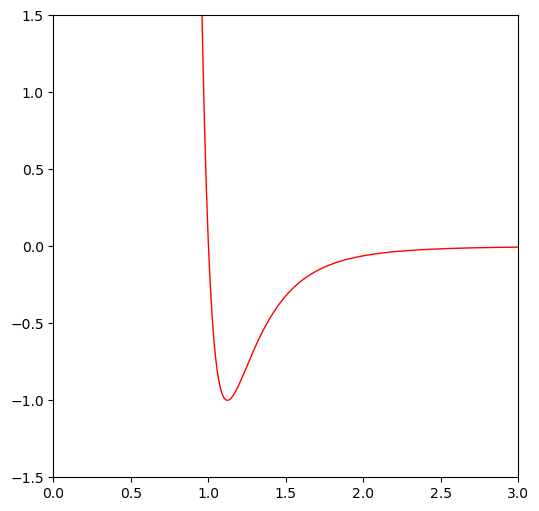

In [18]:
plt.figure(figsize=[6,6])
plt.xlim([0.0, 3.0])
plt.ylim([-1.5, 1.5])
plt.plot(r,E_LJ,'r-',linewidth=1,label=r" $LJ\; pot$") # Red line is unshifted LJ
plt.show()

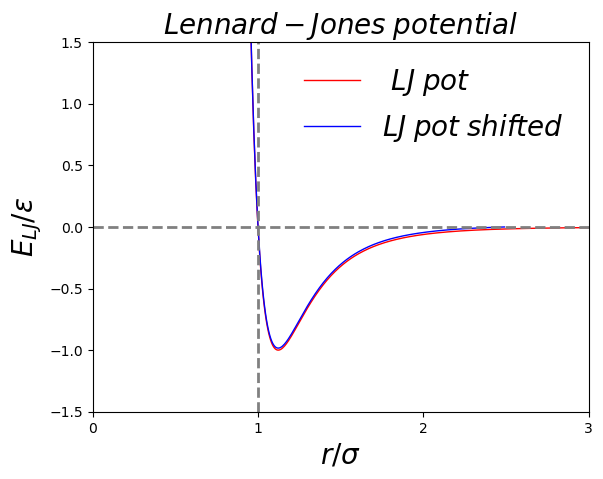

In [19]:
# The cutoff and shifting value
Rcutoff = 2.5
phicutoff = 4.0/(Rcutoff**12)-4.0/(Rcutoff**6) # Shifts the potential so at the cutoff the potential goes to zero

E_LJ_shift = E_LJ - phicutoff # Subtract the value of the potential at r=2.5

plt.plot(r,E_LJ,'r-',linewidth=1,label=r" $LJ\; pot$")
plt.plot(r[:415],E_LJ_shift[:415],'b-',linewidth=1,label=r"$LJ\; pot\; shifted$") # Blue line is shifted

#Plot formatting
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.title(r"$Lennard-Jones\; potential$",fontsize=20)
plt.xlim([0.0,3.0])
plt.ylim([-1.5,1.5])
plt.ylabel(r"$E_{LJ}/\epsilon$",fontsize=20)
plt.xlabel(r"$r/\sigma$",fontsize=20)
plt.legend(frameon=False,fontsize=20)
plt.axhline(0, color='grey',linestyle='--',linewidth=2)
plt.axvline(1, color='grey',linestyle='--',linewidth=2)
plt.show()

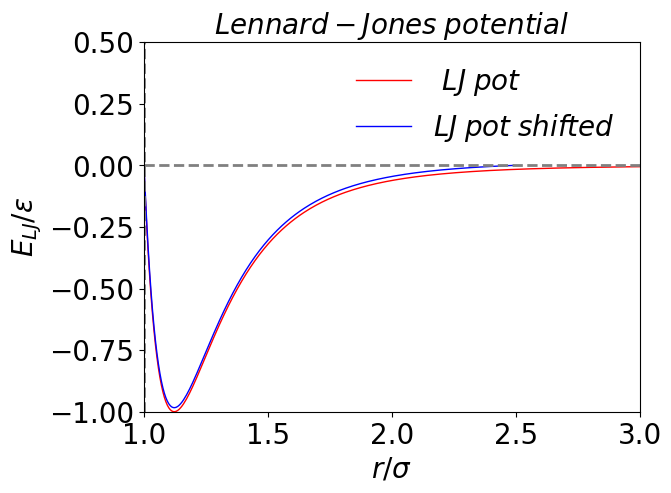

In [20]:
# The cutoff and shifting value
Rcutoff = 2.5
phicutoff = 4.0/(Rcutoff**12)-4.0/(Rcutoff**6) # Shifts the potential so at the cutoff the potential goes to zero

E_LJ_shift = E_LJ - phicutoff # Subtract the value of the potential at r=2.5

plt.plot(r,E_LJ,'r-',linewidth=1,label=r" $LJ\; pot$")
plt.plot(r[:415],E_LJ_shift[:415],'b-',linewidth=1,label=r"$LJ\; pot\; shifted$") # Blue line is shifted

#Plot formatting
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.title(r"$Lennard-Jones\; potential$",fontsize=20)
plt.xlim([1.0,3.0])
plt.ylim([-1.0,0.5])
plt.ylabel(r"$E_{LJ}/\epsilon$",fontsize=20)
plt.xlabel(r"$r/\sigma$",fontsize=20)
plt.legend(frameon=False,fontsize=20)
plt.axhline(0, color='grey',linestyle='--',linewidth=2)
plt.axvline(1, color='grey',linestyle='--',linewidth=2)
plt.show()

In [21]:
def Compute_Forces(pos,acc,ene_pot,epsilon,BoxSize,DIM,N):
    # Compute forces on positions using the Lennard-Jones potential
    # Uses double nested loop which is slow O(N^2) time unsuitable for large systems
    Sij = np.zeros(DIM) # Box scaled units
    Rij = np.zeros(DIM) # Real space units

    #Set all variables to zero
    ene_pot = ene_pot*0.0
    acc = acc*0.0
    virial=0.0

    # Loop over all pairs of particles
    for i in range(N-1):
        for j in range(i+1,N): #i+1 to N ensures we do not double count
            Sij = pos[i,:]-pos[j,:] # Distance in box scaled units
            for l in range(DIM): # Periodic interactions
                if (np.abs(Sij[l])>0.5):
                    Sij[l] = Sij[l] - np.copysign(1.0,Sij[l]) # If distance is greater than 0.5  (scaled units) then subtract 0.5 to find periodic interaction distance.

            Rij = BoxSize*Sij # Scale the box to the real units in this case reduced LJ units
            Rsqij = np.dot(Rij,Rij) # Calculate the square of the distance

            if(Rsqij < Rcutoff**2):
                # Calculate LJ potential inside cutoff
                # We calculate parts of the LJ potential at a time to improve the efficieny of the computation (most important for compiled code)
                rm2 = 1.0/Rsqij # 1/r^2
                rm6 = rm2**3.0 # 1/r^6
                rm12 = rm6**2.0 # 1/r^12
                phi = epsilon*(4.0*(rm12-rm6)-phicutoff) # 4[1/r^12 - 1/r^6] - phi(Rc) - we are using the shifted LJ potential
                # The following is dphi = -(1/r)(dV/dr)
                dphi = epsilon*24.0*rm2*(2.0*rm12-rm6) # 24[2/r^14 - 1/r^8]
                ene_pot[i] = ene_pot[i]+0.5*phi # Accumulate energy
                ene_pot[j] = ene_pot[j]+0.5*phi # Accumulate energy
                virial = virial + dphi*np.sqrt(Rsqij) # Virial is needed to calculate the pressure
                acc[i,:] = acc[i,:]+dphi*Sij # Accumulate forces
                acc[j,:] = acc[j,:]-dphi*Sij # (Fji=-Fij)
    return acc, np.sum(ene_pot)/N, -virial/DIM # return the acceleration vector, potential energy and virial coefficient

In [22]:
def Calculate_Temperature(vel,BoxSize,DIM,N):

    ene_kin = 0.0

    for i in range(N):
        real_vel = BoxSize*vel[i,:]
        ene_kin = ene_kin + 0.5*np.dot(real_vel,real_vel)

    ene_kin_aver = 1.0*ene_kin/N
    temperature = 2.0*ene_kin_aver/DIM

    return ene_kin_aver,temperature

In [23]:
DIM = 2 # Dimensions
N = 64

BoxSize = 8.0 #6.35

volume  = BoxSize**DIM
density = N / volume
print("volume = ", volume, " density = ", density)

pos = np.zeros([N,DIM])

# Place particles on a square lattice to ensure minimum separation
n_grid = int(np.sqrt(N)) # Assuming N is a perfect square for simplicity
if n_grid * n_grid != N:
    print("Warning: N is not a perfect square. Lattice placement might not be ideal.")

spacing = BoxSize / n_grid
particle_index = 0
for i in range(n_grid):
    for j in range(n_grid):
        if particle_index < N:
            pos[particle_index, 0] = (i + 0.5) * spacing
            pos[particle_index, 1] = (j + 0.5) * spacing
            particle_index += 1

# Add a small random displacement to the lattice positions
random_displacement_scale = spacing * 0.5 # Scale the displacement by a fraction of the lattice spacing
pos += (np.random.rand(N, DIM) - 0.5) * random_displacement_scale


# pos = np.genfromtxt('output.dat',skip_header=1) # Load positions from file
# pos = np.random.rand(N,DIM)*BoxSize # Commented out random placement
pos = pos[:,:DIM]/BoxSize # Normalize positions to be within [0, 1)

MassCentre = np.sum(pos,axis=0)/N

for i in range(DIM):
    pos[:,i] = pos[:,i]-MassCentre[i]

volume =  64.0  density =  1.0


In [24]:
# display(pos*BoxSize)

array([[-3.47304779, -3.39592953],
       [-3.62838049, -2.35188089],
       [-3.66762977, -1.49447767],
       [-3.7068776 , -0.45322437],
       [-3.66728736,  0.73125732],
       [-3.52679972,  1.72527201],
       [-3.70675135,  2.2543604 ],
       [-3.36388378,  3.48707376],
       [-2.45831224, -3.5863168 ],
       [-2.68510441, -2.62371832],
       [-2.63688398, -1.43681062],
       [-2.38335012, -0.6389315 ],
       [-2.41200684,  0.48744242],
       [-2.23546748,  1.34553894],
       [-2.51757172,  2.64784414],
       [-2.46481261,  3.38309641],
       [-1.69734208, -3.70883397],
       [-1.58869524, -2.49297992],
       [-1.60652311, -1.33013357],
       [-1.21774773, -0.378463  ],
       [-1.66770394,  0.25919364],
       [-1.47739879,  1.47683116],
       [-1.41311215,  2.42469756],
       [-1.64388096,  3.2778512 ],
       [-0.6554664 , -3.55095992],
       [-0.21292342, -2.74054818],
       [-0.43470801, -1.3702208 ],
       [-0.70637939, -0.73609088],
       [-0.57602827,

(64, 2)


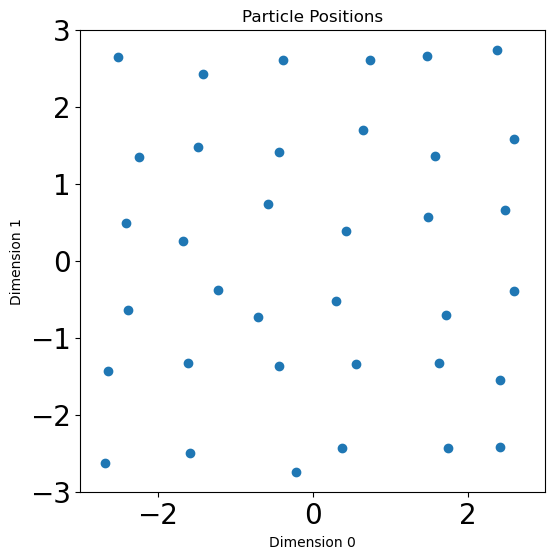

In [25]:
# prompt: I want to create a 2D plot with the x axis as dimension 0 of pos and y-axis as dimension 1 of pos with each point showing as a circle. the limit of the x and y axis should be 0 to 6
print(pos.shape)
plt.figure(figsize=[6,6])
plt.xlim([-3.0, 3.0])
plt.ylim([-3.0, 3.0])
plt.plot(pos[:, 0] * BoxSize, pos[:, 1] * BoxSize, 'o')
plt.xlabel("Dimension 0")
plt.ylabel("Dimension 1")
plt.title("Particle Positions")
plt.show()

In [26]:
# Setting up the simulation
NSteps = 50000 # Number of steps
deltat = 0.0032 # Time step in reduced time units
TRequested = 0.8 # #Reduced temperature
DumpFreq = 500 # Save the position to file every DumpFreq steps
epsilon = 1.0 # LJ parameter for the energy between particles

# Main MD loop
def main(pos,NSteps,deltat,TRequested,DumpFreq,epsilon,BoxSize,DIM):
    # Vectors to store parameter values at each step
    N = np.size(pos[:,1])
    ene_kin_aver = np.ones(NSteps)
    ene_pot_aver = np.ones(NSteps)
    temperature = np.ones(NSteps)
    virial = np.ones(NSteps)
    pressure = np.ones(NSteps)
    ene_pot = np.ones(N)

    vel = (np.random.randn(N,DIM)-0.5)
    acc = (np.random.randn(N,DIM)-0.5)
    # List to store positions at each dump frequency
    all_positions = []

    # Open file which we will save the outputs to
    f = open('traj.xyz', 'w')
    print(NSteps)
    for k in range(NSteps):

        # Refold positions according to periodic boundary conditions
        for i in range(DIM):
            period = np.where(pos[:,i] > 0.5)
            pos[period,i]=pos[period,i]-1.0
            period = np.where(pos[:,i] < -0.5)
            pos[period,i]=pos[period,i]+1.0

        # r(t+dt) modify positions according to velocity and acceleration
        pos = pos + deltat*vel + 0.5*(deltat**2.0)*acc # Step 1

        # Calculate temperature
        ene_kin_aver[k],temperature[k] = Calculate_Temperature(vel,BoxSize,DIM,N)

        # Rescale velocities and take half step
        chi = np.sqrt(TRequested/temperature[k])
        vel = chi*vel + 0.5*deltat*acc # v(t+dt/2) Step 2

        # Compute forces a(t+dt),ene_pot,virial
        acc, ene_pot_aver[k], virial[k] = Compute_Forces(pos,acc,ene_pot,epsilon,BoxSize,DIM,N) # Step 3

        # Complete the velocity step
        vel = vel + 0.5*deltat*acc # v(t+dt/2) Step 4

        # Calculate temperature
        ene_kin_aver[k],temperature[k] = Calculate_Temperature(vel,BoxSize,DIM,N)

        # Calculate pressure
        pressure[k]= density*temperature[k] + virial[k]/volume


        # Print output to file every DumpFreq number of steps
        if(k%DumpFreq==0): # The % symbol is the modulus so if the Step is a whole multiple of DumpFreq then print the values

            f.write("%s\n" %(N)) # Write the number of particles to file
            # Write all of the quantities at this step to the file
            f.write("Energy %s, Temperature %.5f\n" %(ene_kin_aver[k]+ene_pot_aver[k],temperature[k]))
            for n in range(N): # Write the positions to file
                f.write("X"+" ")
                for l in range(DIM):
                    f.write(str(pos[n][l]*BoxSize)+" ")
                f.write("\n")
            all_positions.append(pos.copy() * BoxSize) # Store real space positions
    f.close() # Close the file

    return ene_kin_aver, ene_pot_aver, temperature, pressure, pos, all_positions

In [27]:
ene_kin_aver, ene_pot_aver, temperature, pressure, pos, all_positions = main(pos,NSteps,deltat,TRequested,DumpFreq,epsilon,BoxSize,DIM)

50000


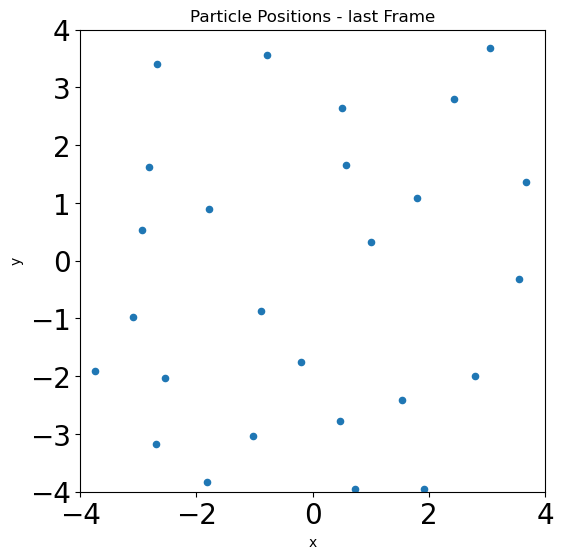

In [28]:
plt.figure(figsize=(6, 6))
plt.xlim([-0.5*BoxSize, 0.5*BoxSize])
plt.ylim([-0.5*BoxSize, 0.5*BoxSize])
plt.scatter(all_positions[-1][:, 0], all_positions[-1][:, 1], s=20)
plt.title("Particle Positions - last Frame")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [29]:
from matplotlib import animation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim([-0.55*BoxSize, 0.55*BoxSize])
ax.set_ylim([-0.55*BoxSize, 0.55*BoxSize])
scatter = ax.scatter([], [], s=60) # s controls marker size

def animate(i):
    # Update the data for the scatter plot with the positions from the i-th frame
    scatter.set_offsets(all_positions[i])
    return scatter,

ani = animation.FuncAnimation(fig, animate, frames=len(all_positions), interval=50, blit=False)

# To display the animation in the notebook
HTML(ani.to_jshtml())

In [ ]:
# For debugging.
# print("Number of frames in animation:", len(all_positions))
# if len(all_positions) > 0:
#    print("Shape of the first frame's positions:", all_positions[0].shape)
#    print("Shape of the last frame's positions:", all_positions[-1].shape)

In [ ]:
# print (ene_kin_aver[10000]) # Removed the incorrect print statement
plt.xlim([10000,20000]) # Corrected the xlim to a valid range
plt.ylim([0,2])
plt.plot(ene_kin_aver,'k-')

In [ ]:
plt.xlim([10000,20000]) # Corrected the xlim to a valid range
plt.ylim([0.6,1.0])
plt.plot(temperature,'k-')

In [ ]:
plt.xlim([10000,20000]) # Corrected the xlim to a valid range
plt.ylim([-1,1])
plt.plot(ene_pot_aver,'k-')

In [ ]:
print("Temperature = ", np.average(temperature[10000:20000]), "+-", 2*np.std(temperature[10000:20000]))

In [ ]:
print("Pressure = ", np.average(pressure[10000:20000]), "+-", 2*np.std(pressure[10000:20000]))